🌃🗺🏡 Satellite Image classifier: a vulnerability indicator for a sustainable future 🌃🗺🏡

![SATELITE IMAGE CLASSIFICATOR: AN VULNERABILTY AND EXPOSER INTENSITY INDICATOR TO A SUSTEABLE FUTURE 🌃🗺🏡](satellite_image.jpg)

image source: www.shutterstock.com

### Libraries and requirements 

In [2]:
#essential
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings 
#tensorflow for resnet50 model 
from keras import Input
from keras.layers import Dense,Add,Flatten, Reshape,Activation,ZeroPadding2D,BatchNormalization,Conv2D,AveragePooling2D,MaxPooling2D
from keras.models import Sequential, Model
from keras.initializers import random_uniform,glorot_uniform
#sklearn for metric and confusion matrix
import itertools
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#for visualization without plt.show()
%matplotlib inline
import tensorflow as tf
from keras import metrics
from keras.metrics import Accuracy
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, recall_score,accuracy_score


### Definition of input variables

In [3]:

# Definition of Required variables
filepath='/home/nara/code/tdavila28/student-challenges/curriculum/Projet_final/EuroSAT/2750'
batch_size=32 #sugested by keras utility
img_height=64 # image_size
img_width=64 # image_size
validation_split=0.2 #good practice suggested
rescale=1.0/255

### Load data using keras utility and rescaling

In [4]:

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split,rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(filepath, image_size=(img_height, img_width), batch_size=batch_size)


Found 27000 files belonging to 10 classes.


In [5]:
# classes of model verification and format  
dataset.class_names #['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
#manually verification of dataset to model 
#for image_batch,labels_batch in dataset:
    #print(image_batch.shape)
    #print(labels_batch.shape)
    #break
#image_batch= (32, 64, 64, 3) #tensor of the shape, i mean a batch of 32 images of shape 64*64*3>(RGB channel )
#labels_batch=(32,) #tensor of the shape. these are coorespondong labels to the 32 images. 

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [6]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=filepath,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical',
                                           )

Found 5400 images belonging to 10 classes.


In [7]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=filepath,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [8]:
type(test_dataset ),type(train_dataset)

(keras.src.preprocessing.image.DirectoryIterator,
 keras.src.preprocessing.image.DirectoryIterator)

In [9]:
train_dataset

### Data Visualization

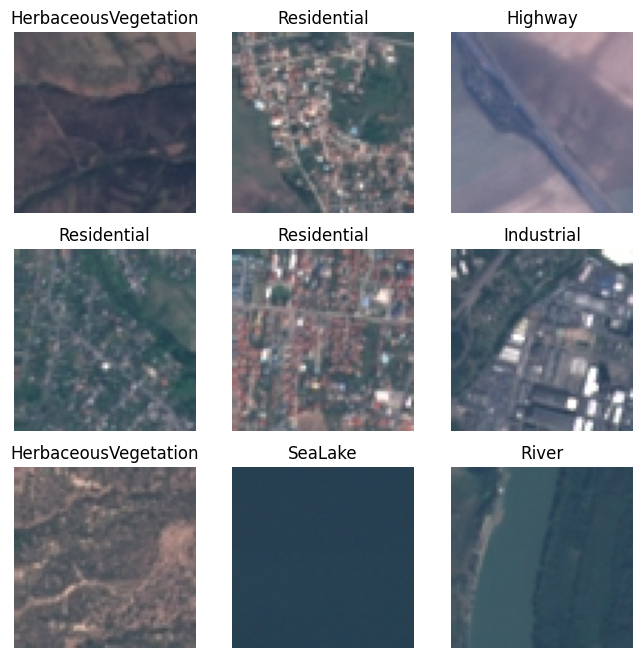

In [10]:
#suggested tensorflow code 
class_names = dataset.class_names
plt.figure(figsize=(8, 8))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        (plt.imshow(images[i].numpy().astype("uint8"))).set_cmap('nipy_spectral') #uint8
        plt.title(class_names[labels[i]])
        plt.axis("off")

Model RESNET5 


In [11]:
type(test_dataset),type(train_dataset )

(keras.src.preprocessing.image.DirectoryIterator,
 keras.src.preprocessing.image.DirectoryIterator)

In [12]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block 
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [13]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [14]:
def ResNet50(input_shape = (64, 64, 3), classes = 10):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

### Model Training

In [15]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [16]:
#from sklearn.metrics import precision_recall_curve, recall_score,accuracy_score

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Accuracy']) #let's do it with accurancy and recall in the same time  #the next loop 
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall()]) #Recall
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_callback]) ## F1-Score

In [16]:
# please increase the epoch for higher accuracy (epochs=100)
%time 
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, batch_size=32)
#corrida 20 epochs
#91 min epoch9 
#209 epoch 19


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs
Epoch 1/20
675/675 [==============================] - 718s 1s/step - loss: 1.5547 - Accuracy: 0.5288 - val_loss: 1.4033 - val_Accuracy: 0.5443
Epoch 2/20
675/675 [==============================] - 619s 917ms/step - loss: 0.9627 - Accuracy: 0.6865 - val_loss: 1.3944 - val_Accuracy: 0.5293
Epoch 3/20
675/675 [==============================] - 620s 918ms/step - loss: 0.8677 - Accuracy: 0.7148 - val_loss: 0.9665 - val_Accuracy: 0.6809
Epoch 4/20
675/675 [==============================] - 620s 919ms/step - loss: 0.7714 - Accuracy: 0.7505 - val_loss: 0.9397 - val_Accuracy: 0.6844
Epoch 5/20
675/675 [==============================] - 621s 920ms/step - loss: 0.6433 - Accuracy: 0.7894 - val_loss: 0.6624 - val_Accuracy: 0.8083
Epoch 6/20
675/675 [==============================] - 622s 921ms/step - loss: 0.6741 - Accuracy: 0.7960 - val_loss: 0.6844 - val_Accuracy: 0.8063
Epoch 7/20
675/675 [==============================] - 622s 921m

In [16]:
#model.save('lulc_20_epoch_recall_10class')

INFO:tensorflow:Assets written to: lulc_20_epoch_recall/assets


INFO:tensorflow:Assets written to: lulc_20_epoch_recall/assets


In [18]:
model.save(r"model_runs/model_20epoch_Accuracy_10class.h5")

/home/nara/.pyenv/versions/3.10.4/envs/artefact/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
from tensorflow.keras.models import load_model
model=load_model(r"model_runs/model_20epoch_recall.h5")

### Visualization of predicted labels and true labels at images 

In [18]:
# Get class names # 
class_names =  dataset.class_names
#testing section 
predictions=model.predict(test_dataset)
predictions
#convert predictions to class labels
predicted_labels=np.argmax(predictions,axis=1)
true_labels=test_dataset.labels

169/169 [==============================] - 23s 130ms/step


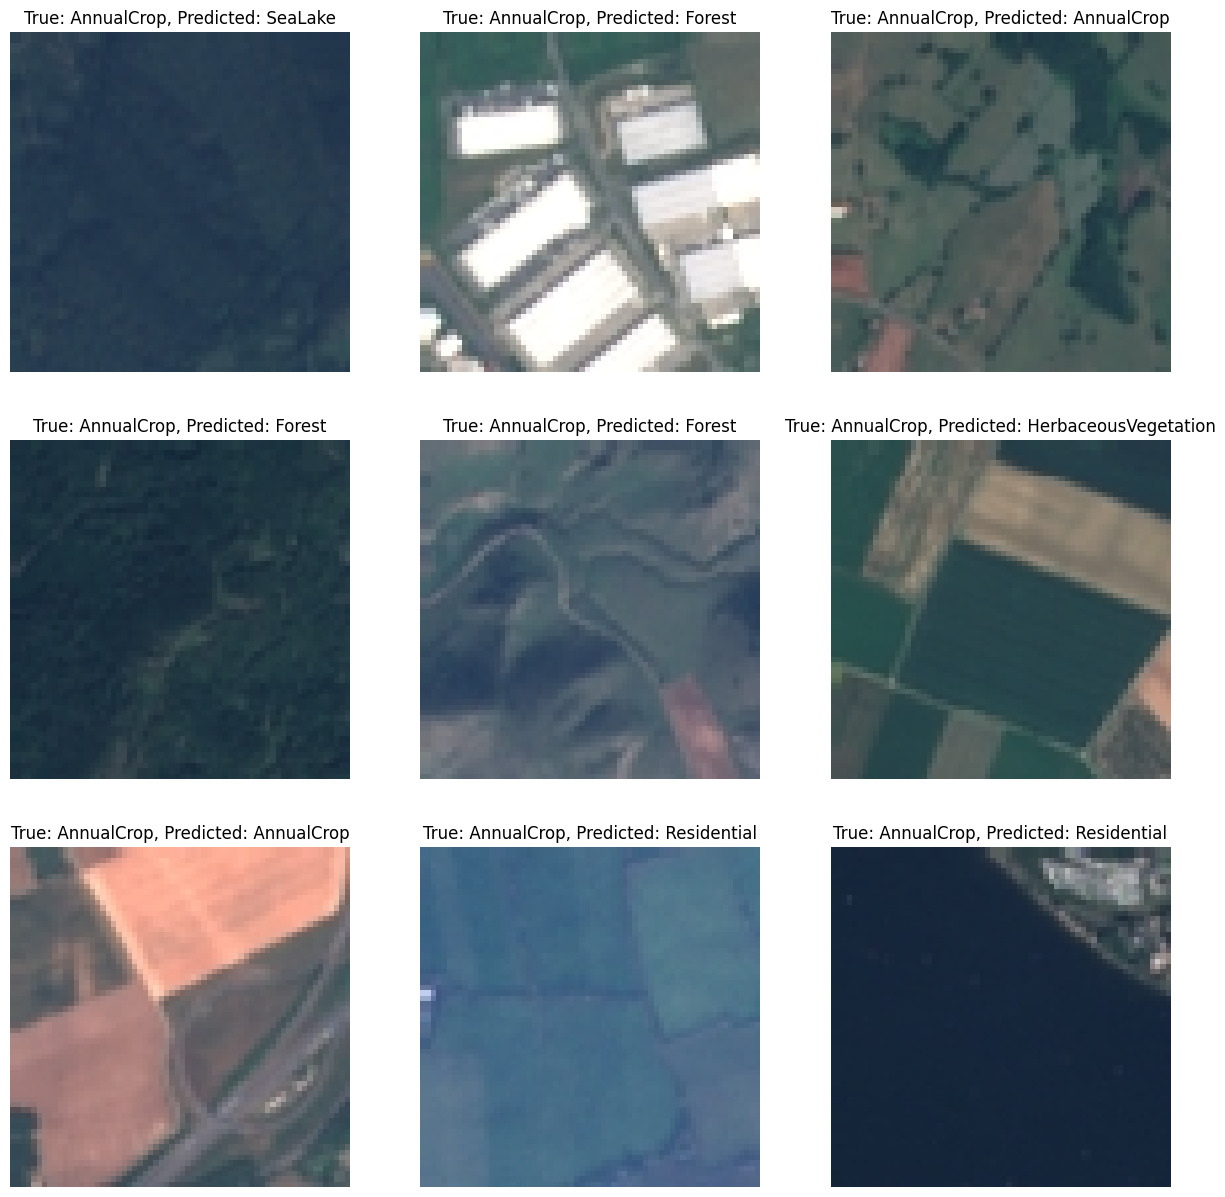

In [41]:
# Set custom figure size
fig = plt.figure(figsize=(15, 15))

# Visualize a few random predictions
num_samples_to_visualize = 9
random_indices = np.random.choice(len(test_dataset), num_samples_to_visualize, replace=False)

for i, index in enumerate(random_indices):
    # Display the image
    image_data = test_dataset[index][0][0] 
    plt.subplot(3, 3, i+1)
    
    # If image is RGB, use this line
    plt.imshow(image_data)
        
    true_label = class_names[true_labels[index]]
    predicted_label = class_names[predicted_labels[index]]
    
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')

plt.show()

### EVALUATION OF MODEL PERFORMANCE (Accuracy and Recall) ATTENTION WITH HISTORY!!

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [ ]:
#analyzing results and visualization 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [25]:
type(test_dataset)

keras.src.preprocessing.image.DirectoryIterator

### VISUALIZATIONS OF IMAGES WITH TRUE AND PREDICTED LABELS 

In [27]:
#VISUALIZATION
#extract true and predicted labels from test_dataset with their image 
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch,verbose=0)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

# visualize random images with correct and predicted labels
num_images_to_visualize = 4  # Change this to the number of images you want to visualize
num_cols = 2
num_rows = num_images_to_visualize // num_cols

# Ensure the number of images to visualize does not exceed the available data
num_images_to_visualize = min(num_images_to_visualize, len(correct_labels))



Visualizing images: 100%|██████████| 4/4 [00:00<00:00, 12.62it/s]


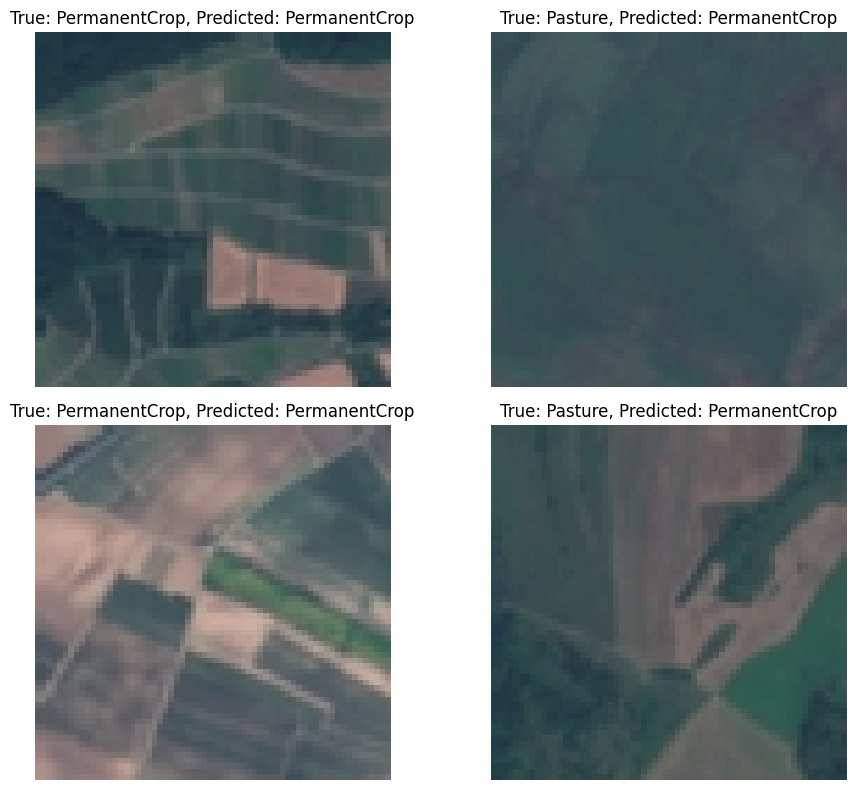

In [20]:
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))  # Customize the figsize as needed

# Reset the iterator to the beginning (optional)
test_dataset.reset()

# Iterate over random indices and plot images with tqdm progress bar
for i in tqdm(range(num_images_to_visualize), desc="Visualizing images"):
    # Get the next batch from the iterator
    image_batch, label_batch = next(test_dataset)

    # Choose a random image from the batch
    idx_in_batch = random.randint(0, len(label_batch) - 1)
    image = image_batch[idx_in_batch]
    true_label = np.argmax(label_batch[idx_in_batch])

    # Compute the predicted label
    preds = model.predict(np.expand_dims(image, axis=0), verbose=0)  # Set verbose to 0 to suppress output
    predicted_label = np.argmax(preds)

    #map numerical indices to class names 
    true_label = class_names[true_label]
    predicted_label = class_names[predicted_label]

    # Plot image on the corresponding subplot
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image)
    ax.set_title(f'True: {true_label}, Predicted: {predicted_label}')
    ax.axis('off')  # Turn off axis labels

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### CONFUSION MATRIX

In [28]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch,verbose=0)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 139ms/step


In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 907,   12,   14,   14,    0,   25,   39,    2,   19,    7],
       [   0, 1020,    0,    1,    0,    5,    0,    0,    2,   25],
       [  18,   74,  787,   18,    8,   10,  120,    5,   24,    4],
       [  16,    1,   12,  746,   49,   11,   52,   13,   17,    0],
       [   0,    0,    8,   18,  820,    0,   11,   30,    3,    0],
       [  11,  145,    6,    8,    1,  499,   32,    2,   10,    2],
       [  33,    1,   59,   23,   11,   21,  745,    7,    6,    0],
       [   0,    0,   13,   11,   33,    1,    6, 1008,    0,    0],
       [  45,    6,    5,   78,    4,   45,   20,    0,  671,    3],
       [  11,    7,    2,    0,    2,    2,    0,    0,    6, 1048]])

In [31]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 907   12   14   14    0   25   39    2   19    7]
 [   0 1020    0    1    0    5    0    0    2   25]
 [  18   74  787   18    8   10  120    5   24    4]
 [  16    1   12  746   49   11   52   13   17    0]
 [   0    0    8   18  820    0   11   30    3    0]
 [  11  145    6    8    1  499   32    2   10    2]
 [  33    1   59   23   11   21  745    7    6    0]
 [   0    0   13   11   33    1    6 1008    0    0]
 [  45    6    5   78    4   45   20    0  671    3]
 [  11    7    2    0    2    2    0    0    6 1048]]


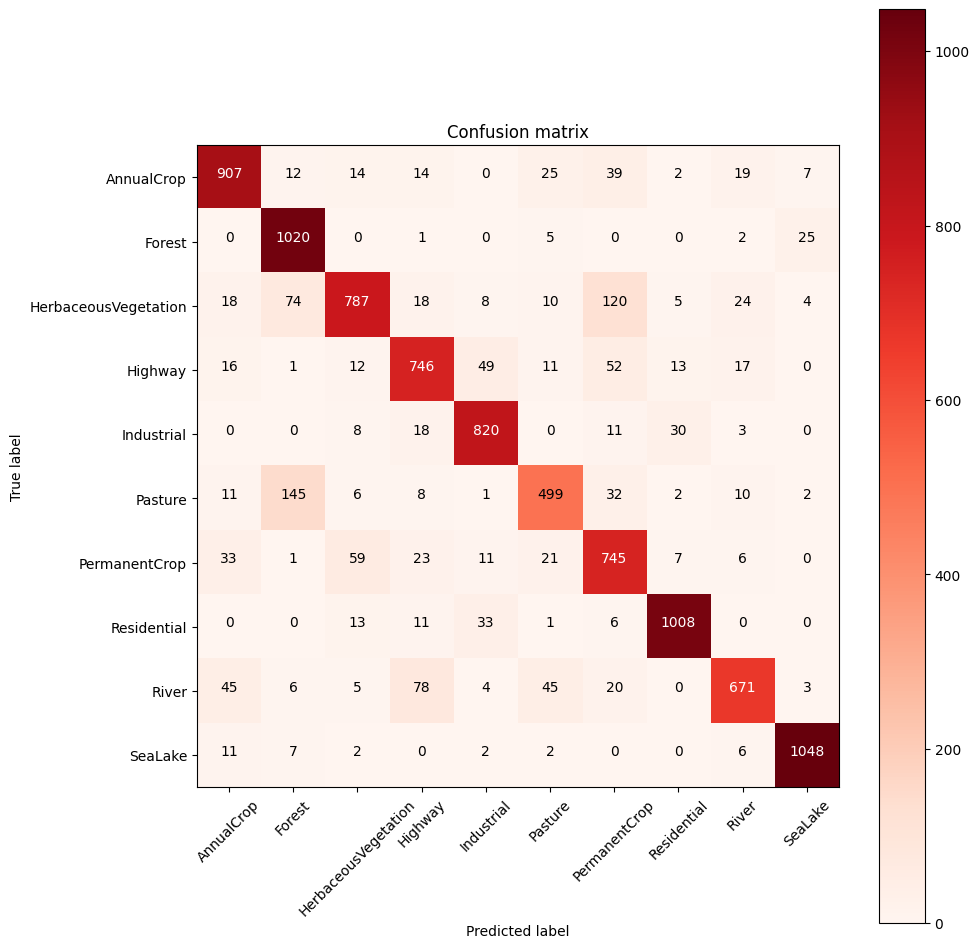

In [32]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

In [ ]:
#calculate true false and true positives of the cm in order to have an argument around why some classes are not making a good job in the prediction!
#Notes: 
#a 40 epochs, se clasifica muy bien seaLake, Residential, FOrest y Anual Crop. y Peor, Hihway, Pasture. 
# a 20 epochs,  

#### IDEA INSPIRATION AND CODE FRAMEWORK SOURCES -REFERENCES:
#### 1.https://www.researchgate.net/publication/263336077_Land_UseCover_Vulnerability_Index_and_Exposer_Intensity
#### 2.https://www.kaggle.com/competitions/asal-land-cover-classification-haick-2022
#### 3.https://www.tensorflow.org/tutorials/load_data/images



